In [2]:
import os

import pandas as pd
import numpy as np
import math
from scipy.stats import beta, gamma

import matplotlib.pyplot as plt
import seaborn as sns

# Part 2: Modeling and analysis of continuous metrics



## Context

In this second example, we need to look at the average order value in the experiment. We hypothesise that the changes will show a higher AOV. We'll model the AOV/Revenue generated by each user as a random variable such as

$$R=X\cdot{Y}$$

where, as before, conversion rate $X$ is a Bernoulli random variable refering to conversion, with probability $\theta: X \sim Ber(\theta)$

and $Y$, is an Exponential random variable refering to the AOV if there's a conversion, with rate parameter $\mu: Y \sim Exp(\mu)$

Under this model, we have that the average revenue per sale (AOV) is given by $\frac{1}{\mu}$

and the average revenue per visitor (RPV) is given by $\frac{\theta}{\mu}$

In [3]:
df_prior_data = pd.read_csv(os.path.join('../data/external', 'prior_data_revenue.csv'), index_col=0)

print(df_prior_data.head())
print(df_prior_data.shape)

                             session_id  converted  revenue
0  9d7e7eb0-51b7-11eb-8260-5f9daf0a778a          0      0.0
1  9de6d810-5415-11eb-a8fc-f726e66bec66          0      0.0
2  811b4650-544f-11eb-a0a0-6179589e48d9          0      0.0
3  f5722f30-53b1-11eb-a585-cf5fe015baf0          0      0.0
4  52a467f0-5064-11eb-8725-8796151a24ab          0      0.0
(162661, 3)


In [4]:
conversion_rate = df_prior_data['converted'].sum() / len(df_prior_data)

converted = df_prior_data[df_prior_data['converted']==1]
aov = converted['revenue'].mean()

print(f'Prior conversion rate: {round(conversion_rate, 3)}')
print(f'AOV: {round(aov, 3)}')

print(f'Rate parameter for AOV is: {round(1/aov, 3)}')
print(f'Revenue per Visitor is: {round(conversion_rate*aov, 3)}')

Prior conversion rate: 0.015
AOV: 61.215
Rate parameter for AOV is: 0.016
Revenue per Visitor is: 0.945


#### Choosing a prior

For simplicity, we'll use the same Beta prior for conversion probability $\theta$ as in part 1. 

In the case of $\mu$, we'll need a distribution over $[0, \infty)$ that is also a good conjugate prior. Common practice is to use the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). For our case, we'll use a very weak $Gamma(0.1, 0.1)$

#### Setting a loss threshold

With a chosen prior, let's now choose our $\epsilon$, which is the highest expected loss we're willing to accept should we make the mistake of choosing the wrong variant. Let's assume product department decides that this relative loss can be 0.5%



In [5]:
epsilon = conversion_rate * 0.5
print(f'Loss threshold: {epsilon}')

Loss threshold: 0.007715432709746037


#### The experiment

Let's assume as in notebook 1 that the experiment run for two weeks. 

Again, we need to use the experiment data to calculate the posterior distributions, and then calculate the probability of each variant being better, and also the expected loss of wrongly choosing a variant.

In [6]:
df_experiment_data = pd.read_csv(os.path.join('../data/external', 'experiment_data_revenue.csv'), index_col=0)

print(df_experiment_data.head())
print(df_experiment_data.shape)

                             session_id      group  converted  revenue
0  1d6bf6b0-5de9-11eb-84ff-e13d0a529a5d    control          0      0.0
1  99665250-5f34-11eb-8b64-652bb6889046    control          0      0.0
2  65301aa0-64bd-11eb-a175-95bd70510172    control          0      0.0
3  7d0ac920-5dfd-11eb-9b10-1992247d2157    control          0      0.0
4  68134840-60ea-11eb-96a0-99f53f37b6b1  treatment          0      0.0
(494151, 4)


In [7]:
results = df_experiment_data.groupby('group').agg({'session_id': pd.Series.nunique,
                                                   'converted': sum,
                                                   'revenue': sum})

results.rename({'session_id': 'sample_size'}, axis=1, inplace=True)

results['conversion_rate'] = results['converted'] / results['sample_size']
results['aov'] = results['revenue'] / results['converted']

print(results)

           sample_size  converted        revenue  conversion_rate        aov
group                                                                       
control         190557       3374  198427.177708         0.017706  58.810663
treatment       180753       3578  217693.238661         0.019795  60.842157


Upon superficial inspection, it looks like treatment group had better conversion rate and better AOV. 

####  Posteriors

We saw before in part 1, how the posterior for conversion rate was calculated to update our beliefs about $\lambda$:

##### Beta (conversion rate)

In [8]:
# set alpha & beta priors
prior_alpha = round(conversion_rate, 2)*150 + 1
prior_beta = 150 + 1 - round(conversion_rate, 2)*150
prior = beta(prior_alpha, prior_beta)


control = beta(prior_alpha + results.loc['control', 'converted'], \
               prior_beta + results.loc['control', 'sample_size'] - results.loc['control', 'converted'])

treatment = beta(prior_alpha + results.loc['treatment', 'converted'],\
                 prior_beta + results.loc['treatment', 'sample_size'] - results.loc['treatment', 'converted'])

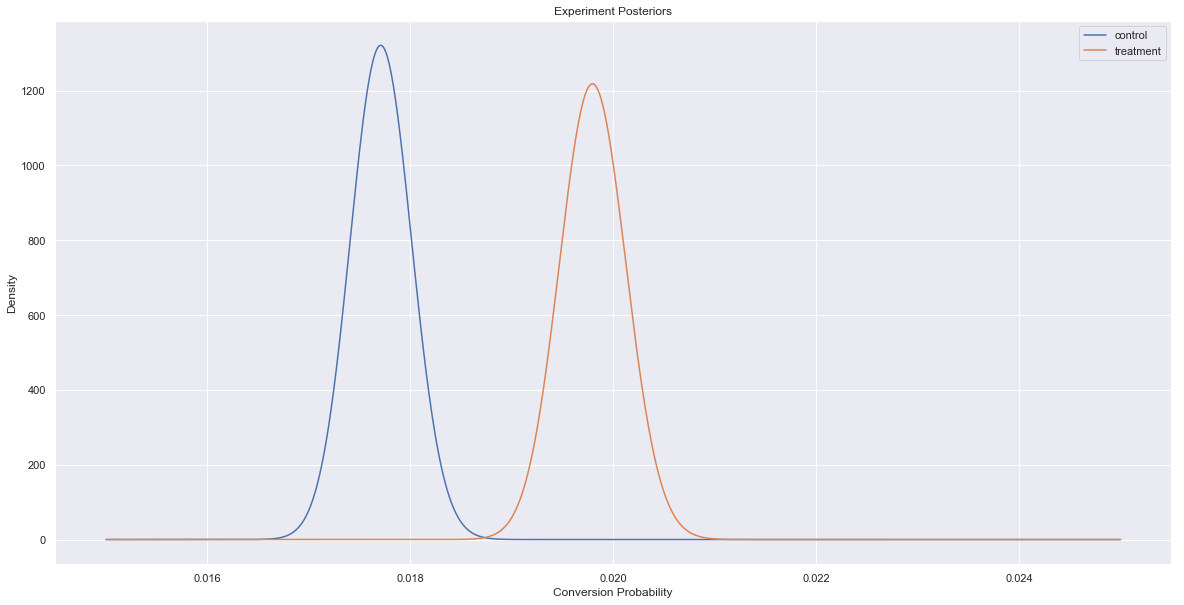

In [9]:
sns.set(rc={'figure.figsize':(20,10)})

fig, ax = plt.subplots()

x = np.linspace(0.015, 0.025, 1000)

ax.plot(x, control.pdf(x), label='control')
ax.plot(x, treatment.pdf(x), label='treatment')

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend();

##### Gamma (AOV)

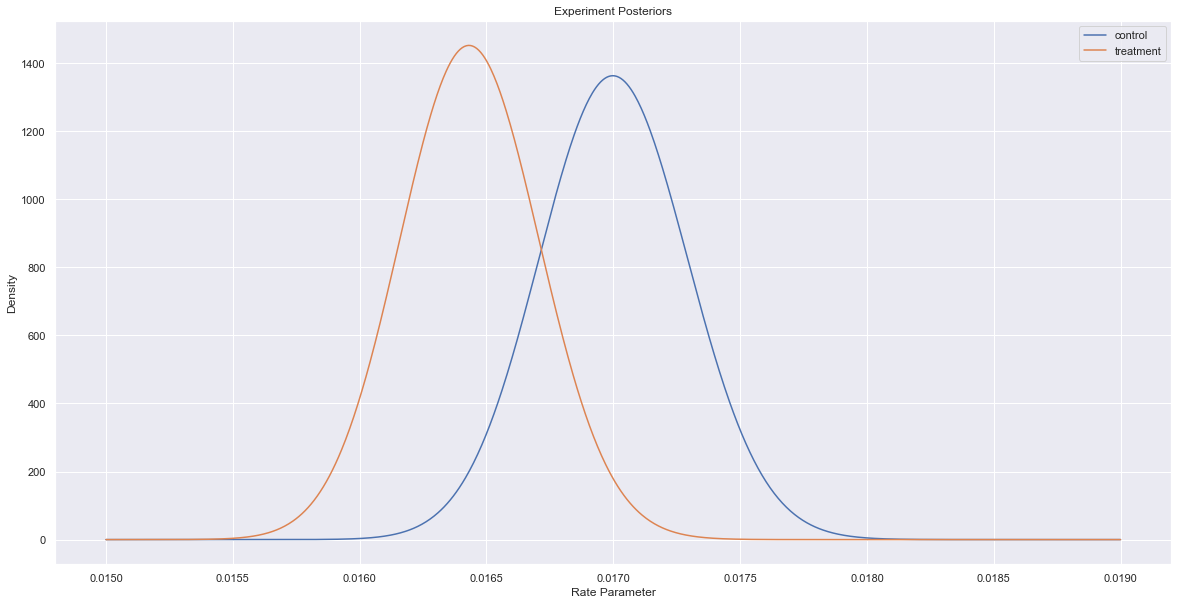

In [10]:
control_rr = gamma(
    a=(0.1 + results.loc['control', 'converted']),\
    scale=(0.1/(1 + (0.1)*results.loc['control', 'converted']*results.loc['control', 'aov'])))

treatment_rr = gamma(
    a=(0.1 + results.loc['treatment', 'converted']),\
    scale=(0.1/(1 + (0.1)*results.loc['treatment', 'converted']*results.loc['treatment', 'aov'])))

fig, ax = plt.subplots()

x = np.linspace(0.015, 0.019, 1000)

ax.plot(x, control_rr.pdf(x), label='control')
ax.plot(x, treatment_rr.pdf(x), label='treatment')
ax.set_xlabel('Rate Parameter')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend();

These posteriors show some overlapping, so it's not apparently clear that one is better than the other. Remember the rate parameter being lower means a higher average revenue per sale, so treatment seems to be performing better.

Let's plot the distributions for AOV under these same posteriors to get a less confusing visualization:

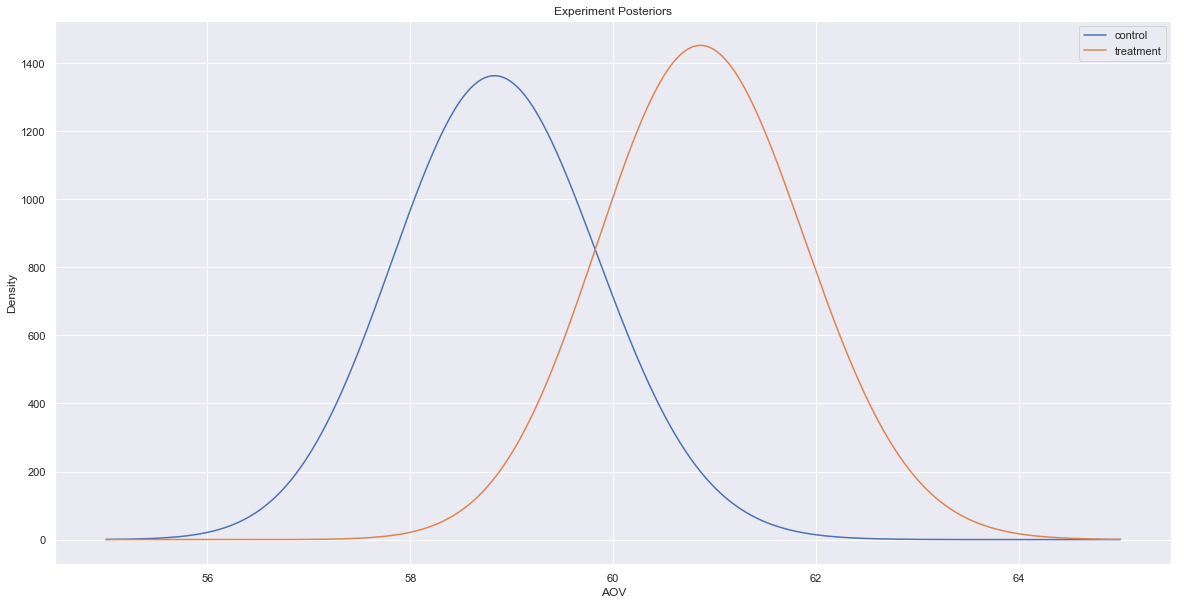

In [11]:
fig, ax = plt.subplots()

x = np.linspace(55,65,1000)
z = [1/i for i in x]

ax.plot(x, control_rr.pdf(z), label='control')
ax.plot(x, treatment_rr.pdf(z), label='treatment')

ax.set_xlabel('AOV')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend();

So, treatment performs better in conversion rate, and has a higher AOV, although this last metric isn't as clear. Let's run the simulations:

In [13]:
# simulations for conversion rate
control_conversion_simulation = np.random.beta(
    prior_alpha + results.loc['control', 'converted'],\
    prior_beta + results.loc['control', 'sample_size'] - results.loc['control', 'converted'], size=100000)

treatment_conversion_simulation = np.random.beta(
    prior_alpha + results.loc['treatment', 'converted'],\
    prior_beta + results.loc['treatment', 'sample_size'] - results.loc['treatment', 'converted'], size=100000)

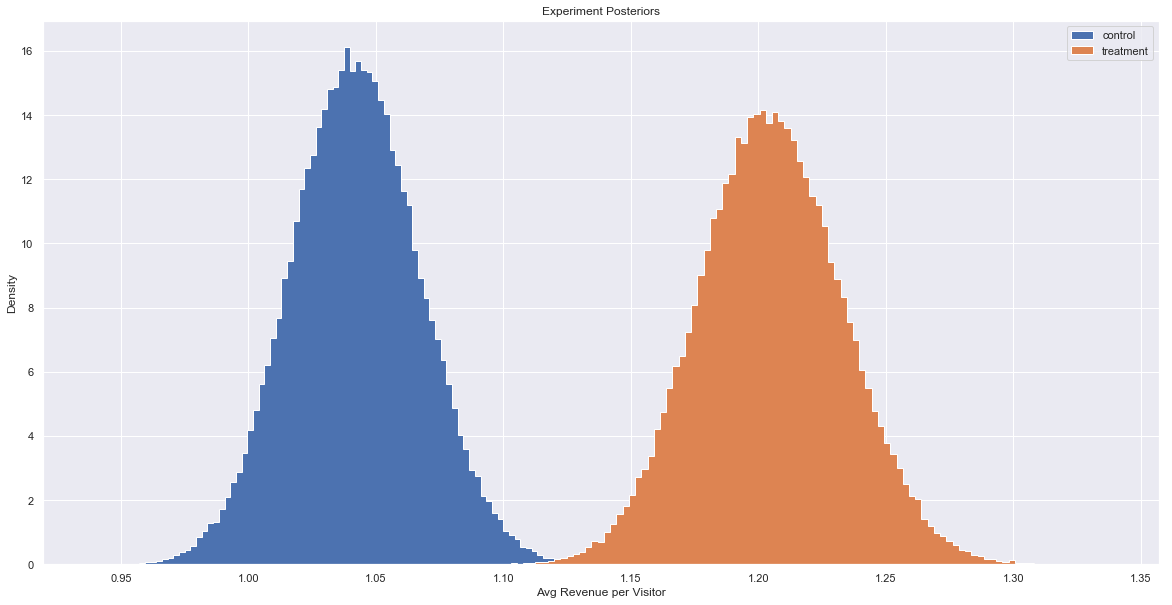

In [14]:
# simulations for AOV
control_revenue_simulation = np.random.gamma(
    shape=(0.1 + results.loc['control', 'converted']),\
    scale=(0.1/(1 + (0.1)*results.loc['control', 'converted']*results.loc['control', 'aov'])),\
    size=100000)

treatment_revenue_simulation = np.random.gamma(
    shape=(0.1 + results.loc['treatment', 'converted']),\
    scale=(0.1/(1 + (0.1)*results.loc['treatment', 'converted']*results.loc['treatment', 'aov'])),\
    size=100000)

# avgs
control_avg_purchase = [i/j for i,j in zip(control_conversion_simulation, control_revenue_simulation)]
treatment_avg_purchase = [i/j for i,j in zip(treatment_conversion_simulation, treatment_revenue_simulation)]

fig, ax = plt.subplots()

x = np.linspace(55,65,1000)

ax.hist(control_avg_purchase, density=True, label='control', histtype='stepfilled', bins=100)
ax.hist(treatment_avg_purchase, density=True, label='treatment', histtype='stepfilled', bins=100)
ax.set_xlabel('Avg Revenue per Visitor')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend();

#### Probability of treatment being better

As before, we'll now calculate $p(\frac{\lambda_{t}}{\theta_{t}}\geq\frac{\lambda_{c}}{\theta_{c}})$ and $E[L](t)$

In [15]:
treatment_won = [i <= j for i,j in zip(control_avg_purchase, treatment_avg_purchase)]
chance_to_beat_ctrl = np.mean(treatment_won)

print(f'Chance of treatment beating control: {round(chance_to_beat_ctrl, 3)}')

Chance of treatment beating control: 1.0


In [16]:
loss_control = [max(j - i, 0) for i,j in zip(control_avg_purchase, treatment_avg_purchase)]
loss_treatment = [max(i - j, 0) for i,j in zip(control_avg_purchase, treatment_avg_purchase)]
all_loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]
expected_loss_control = np.mean(all_loss_control)
expected_loss_treatment = np.mean(all_loss_treatment)

print(f'Expected loss of choosing control: {round(expected_loss_control, 3)}\n\
Expected loss of choosing treatment: {round(expected_loss_treatment, 3)}')

Expected loss of choosing control: 0.163
Expected loss of choosing treatment: 0.0


In [17]:
if expected_loss_treatment < epsilon or expected_loss_control < epsilon:
    print(f'Test reached significance')
else:
    print(f'No variant is below loss threshold')

Test reached significance
